# PK Modelling Project - Mirtazapine
Step A - Generating simulated plasma concentration trajectory data from PK parameters in literature

In [1]:
# Import basic dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import os
import glob
import time
import pickle

# Import local scikit-pk (skpk) library - https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path
import sys
sys.path.append(r'C:\Users\klty0\Desktop\scikit-pk\src')
#sys.path.append(r'C:\Users\Kenneth Leung\Desktop\scikit-pk\src')

import skpk

# Import ODE modules
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import differential_evolution

from sklearn.metrics import auc

In [2]:
# Graph settings
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Neue Einstellung'
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['font.size'] = 12
mpl.rc('axes', titlesize=18, titleweight=20, labelsize=14, facecolor=[0.9,0.9,0.9], edgecolor=[0.5, 0.5, 0.5], linewidth=0.5)
mpl.rc('xtick', labelsize=12, color=[0.3,0.3,0.3])
mpl.rc('ytick', labelsize=12)
mpl.rc('lines', linewidth=3, markersize=10)
mpl.rc('legend', fontsize=12)
mpl.rc('axes', axisbelow=True)
savefigOpts = {'dpi': 100, 'transparent': True}

font_dirs = [r'C:\Users\klty0\Dropbox\Holmusk\Holmusk Templates\Fonts', ]
#font_dirs = [r'C:\Users\Kenneth Leung\Dropbox\Holmusk\Holmusk Templates\Fonts', ]
font_files = mpl.font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = mpl.font_manager.createFontList(font_files)
mpl.font_manager.fontManager.ttflist.extend(font_list)

In [3]:
color_scheme = ['#11151D', '#3360CC', '#77B55B'] #Black, Blue, Green

#### Data Preparation
Creating list of lists with elements [subject_id, gender, age mean, age std]  
For gender, 0 = Male and 1 = Female

In [4]:
list_of_attr = [
    [1,0,24,4],
    [2,0,25,5],
    [3,0,25,4], 
    [4,0,51,8], 
    [5,0,68,5], 
    [6,0,33,6], 
    [7,0,69,3], 
    [8,0,21,1], 
    [9,0,23,4], 
    [10,0,27,9], 
    [11,0,28,6], 
    [12,0,22,1], 
    [13,1,23,3], 
    [14,1,51,4], 
    [15,1,40,8], 
    [16,1,68,3], 
    [17,1,23,6],
    [18,0,23,4],
    [19,0,25,4],
    [20,0,25,4],
    [21,0,32,4],
    [22,0,33,6],
    [23,0,69,3],
    [24,0,23,4],
    [25,0,24,4],
    [26,0,25,4],
    [27,0,26,7],
    [28,0,29,7],
    [29,0,30,8],
    [30,0,33,7],
    [31,0,32,4],
    [32,0,23,4],
    [33,0,25,4],
    [34,0,32,4],
    [35,0,23,4],
    [36,0,25,4],
    [37,0,25,4],
    [38,0,23,4],
    [39,1,40,8],
    [40,1,68,3],
    [41,1,23,4],
    [42,1,34,10],
]

In [5]:
df_attr = pd.DataFrame(list_of_attr, columns = ['subject_id','gender','age_mean','age_sd'])

In [6]:
# Create dataframe of PK parameters (Subject ID, Cmax mean, Cmax SD, Tmax mean, Tmax SD, AUC mean, AUC SD, Study Reference)
list_of_pk_paras = [
    [1, 32.3, 11.4, 1.65, 0.70, 345, 103, 20, 'Single', 15],
    [2, 32.5, 9.7, 1.50, 0.60, 281, 83, 21, 'Single', 15],
    [3, 31.6, 12.8, 1.82, 0.71, 216, 46, 22, 'Single', 15],
    [4, 42.5, 16.3, 1.20, 0.30, 362, 66, 23, 'Single', 15],
    [5, 40.6, 13.8, 1.45, 0.73, 486, 161, 24, 'Single', 15],
    [6, 32.1, 8.1, 1.67, 0.65, 355, 199, 25, 'Single', 20],
    [7, 48.4, 20.1, 1.59, 0.74, 647, 294, 25, 'Single', 20],
    [8, 67.7, 20.6, 1.04, 0.10, 459, 136, 26, 'Single', 30],
    [9, 74.4, 23.5, 1.41, 0.74, 614, 177, 27, 'Single', 30],
    [10, 56.1, 13.9, 1.42, 0.56, 562, 134, 28, 'Single', 30],
    [11, 74.5, 37.8, 1.53, 0.78, 570, 137, 29, 'Single', 30],
    [12, 113.0, 55.8, 1.21, 0.40, 808, 285, 26, 'Single', 45],
    [13, 42.0, 8.2, 1.58, 0.68, 445, 94, 21, 'Single', 15],
    [14, 24.7, 6.9, 1.80, 0.80, 397, 218, 23, 'Single', 15],
    [15, 36.9, 11.3, 1.72, 1.00, 673, 248, 25, 'Single', 20],
    [16, 45.6, 20.2, 2.03, 1.64, 770, 270, 25, 'Single', 20],
    [17, 88.8, 38.7, 2.09, 1.84, 950, 298, 29, 'Single', 30],
    [18, 34.2, 13.4, 1.54, 0.51, 294, 100, 30, 'Multiple', 15],
    [19, 39.0, 12.0, 2.20, 1.50, 409, 116, 31, 'Multiple', 15],
    [20, 41.8, 7.7, 1.47, 0.75, 252, 48, 22, 'Multiple', 15],
    [21, 30.6, 7.8, 2.02, 1.11, 282, 51, 32, 'Multiple', 15],
    [22, 45.9, 24.3, 1.33, 0.43, 386, 170, 25, 'Multiple', 20],
    [23, 51.6, 29.4, 2.41, 1.66, 693, 357, 25, 'Multiple', 20],
    [24, 84.2, 36.5, 1.62, 0.82, 618, 205, 30, 'Multiple', 30],
    [25, 76.0, 33.0, 1.99, 1.65, 589, 142, 33, 'Multiple', 30],
    [26, 80.0, 24.0, 2.60, 1.40, 900, 254, 31, 'Multiple', 30],
    [27, 55.0, 8.9, 2.96, 1.24, 630, 160, 34, 'Multiple', 30],
    [28, 80.4, 18.5, 1.10, 0.30, 706, 235, 35, 'Multiple', 30],
    [29, 62.5, 15.8, 2.10, 1.08, 635, 196, 36, 'Multiple', 30],
    [30, 89.0, 21.0, 1.36, 0.39, 761, 140, 37, 'Multiple', 30],
    [31, 63.8, 16.8, 2.08, 0.93, 553, 96, 32, 'Multiple', 30],
    [32, 118.3, 47.3, 1.33, 0.85, 908, 308, 30, 'Multiple', 45],
    [33, 113.0, 29.0, 2.90, 1.80, 1350, 353, 31, 'Multiple', 45],
    [34, 102.1, 37.5, 1.79, 1.03, 786, 176, 32, 'Multiple', 45],
    [35, 141.2, 40.6, 1.06, 0.24, 1135, 247, 30, 'Multiple', 60],
    [36, 158.0, 41.0, 2.70, 1.60, 1793, 447, 31, 'Multiple', 60],
    [37, 181.0, 44.0, 3.10, 1.70, 2149, 476, 31, 'Multiple', 75],
    [38, 227.5, 31.1, 1.67, 0.58, 1797, 446, 30, 'Multiple', 80],
    [39, 59.9, 21.4, 2.33, 1.62, 769, 234, 25, 'Multiple', 20],
    [40, 62.0, 27.6, 2.31, 1.43, 860, 238, 25, 'Multiple', 20],
    [41, 81.7, 26.9, 2.29, 1.03, 958, 272, 34, 'Multiple', 30],
    [42, 80.0, 16.0, 1.39, 0.42, 785, 173, 37, 'Multiple', 30],
]

In [7]:
df_pk_paras = pd.DataFrame(list_of_pk_paras, columns = ['subject_id','Cmax_mean','Cmax_sd','Tmax_mean','Tmax_sd',
                                                        'AUC_mean','AUC_sd','reference','dosing', 'dose'])

In [8]:
df_subject_master = df_pk_paras.merge(df_attr, on = 'subject_id')

### Keeping only the 16 cohorts with actual data

In [10]:
subject_id_list = [3,6,7,15,16,19,20,22,23,25,26,33,36,37,39,40]

In [11]:
df_16_subjects = df_subject_master[df_subject_master['subject_id'].isin(subject_id_list)]

In [12]:
df_16_subjects['gender'].value_counts()

0    12
1     4
Name: gender, dtype: int64

In [13]:
df_16_subjects['age_mean'].mean()

38.6875

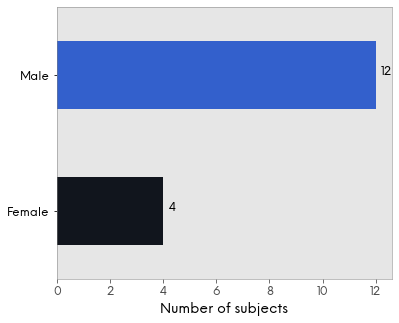

In [19]:
plt.figure(figsize=(6,5))
ax = df_16_subjects['gender'].value_counts().sort_values().plot(kind = 'barh', color = color_scheme[:2]);
ax.set_yticklabels(['Female','Male'])
ax.set_xlabel('Number of subjects')
plt.text(x=df_16_subjects['gender'].value_counts()[0] + 0.2, y=1 , s=f"{df_16_subjects['gender'].value_counts()[0]}",
         c = 'black')
plt.text(x=df_16_subjects['gender'].value_counts()[1] + 0.2, y=0 , s=f"{df_16_subjects['gender'].value_counts()[1]}", 
         c = 'black')
plt.savefig('./Images/gender_distribution.png', **savefigOpts)

### Distributions

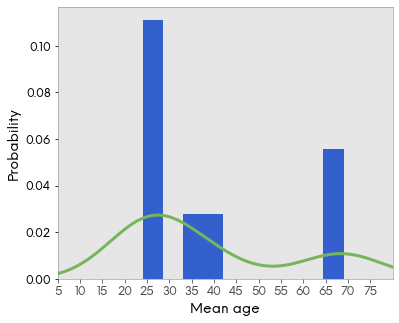

In [20]:
plt.figure(figsize = (6,5))
plt.xticks(np.arange(5,76,5))
plt.hist(df_16_subjects["age_mean"], density = True, color = color_scheme[1]);
plt.xlim(5, 80)
df_16_subjects["age_mean"].plot.kde(bw_method = 0.5, color = color_scheme[2]); 
plt.xlabel('Mean age');
plt.ylabel('Probability');
plt.savefig('./Images/age_histogram.png', **savefigOpts)

In [21]:
df_16_subjects["age_mean"].value_counts().sort_index()

24    1
25    7
33    2
40    2
68    2
69    2
Name: age_mean, dtype: int64

In [14]:
df_age_band1 = df_subject_master.loc[df_subject_master["age_mean"] <= 25]
df_age_band1['age_mean'].mean()

23.714285714285715

In [15]:
df_age_band2 = df_subject_master.loc[(df_subject_master["age_mean"] >= 26) & (df_subject_master["age_mean"] <= 59)]
df_age_band2['age_mean'].mean()

34.4375

In [16]:
df_age_band3 = df_subject_master.loc[df_subject_master["age_mean"] >= 60]
df_age_band3['age_mean'].mean()

68.4

<a name="part2"></a>
#### Setting Up Differential Equations

Develop differential equations for a two-compartmental model (central compartment and peripheral compartment) for Mirtazapine.  

C0 is the additional term involving drug absorption into the central compartment for oral route, where C0(t=0) = Dose * Bioavailability (F).   
If IV route, can assign the term $k_a C_0(t)$ as 0.  

For this experiment, to start with oral administration first

Reference: https://sites.ualberta.ca/~csps/JPPS2(3)/F.Khorasheh/Application-Khorasheh.pdf  


$\frac{dC_0(t)}{dt} = -k_a C_0(t)$

$\frac{dC_1(t)}{dt} = k_a C_0(t) - (k_{12} + k_e) C_1(t) + k_{21} C_2(t) $

$\frac{dC_2(t)}{dt} = k_{12} C_1(t) - k_{21} C_2(t)$

We express the ODE problem with the following equation  

$\frac{dC}{dt} = \textbf{A}*\textbf{C} $

where $\frac{dC}{dt}$ is a $n x 1$ matrix, $\textbf{A}$ is a $n x n$ matrix, and $\textbf{C}$ is a $n x 1$ matrix (where n = number of compartments)

**C0** = Initial drug concentration (GI tract compartment not considered part of two-compartment model)  
**C1** = Drug concentration in Central Compartment (1)  
**C2** = Drug concentration in Peripheral Compartment (2)  
**ka** = Absorption rate constant  
**k12** = Distribution rate constant from Compartment 1 (Central) to 2 (Peripheral)  
**k21** = Distribution rate constant from Compartment 2 (Peripheral) to 1 (Central)  
**ke** = Elimination rate constant

In [17]:
# Generate compartments and model instances to create coefficient matrix
C0 = skpk.Cmt(0, 'Absorption (GI Tract)', 1)
C1 = skpk.Cmt(1, 'Central')
C2 = skpk.Cmt(2, 'Peripheral')
C3 = skpk.Cmt(3, 'External / Elimination')

pkmodel = skpk.Model('Mirtazapine')
pkmodel.add_cmt([C0, C1, C2, C3])

0-Absorption (GI Tract) compartment successfully generated
1-Central compartment successfully generated
2-Peripheral compartment successfully generated
3-External / Elimination compartment successfully generated
 Model named Mirtazapine successfully generated


In [18]:
# Pre-defined parameters
n = 3 # Include GI tract compartment in n (number of compartments)
F = 0.497 # Bioavailability

np.set_printoptions(suppress=True)
period_start = 0
period_end = 120
intervals = 7201 # Minutes in 120 hours
time_horizon = np.around(np.linspace(period_start, period_end, intervals), decimals=3)

In [19]:
# Define dcdt function of ODE (dot multiplication of coefficient matrix and concentration)
def dC(t,C,A):
   
    # Dot multiplication of A coefficient matrix (n x n) with concentration vector C (n x 1) 
    dCdt = np.dot(A, C)
    
    # Returns dCdt as n x 1 vector (dC0/dt, dC1/dt, dC2/dt)
    return dCdt

In [20]:
# Create function that generates coefficient matrix and runs solve_ivp
def ode_solver(p, subject_id):
    
    ka, k12, k21, ke = p    
       
    # Add links based on parameters (p) passed as arguments
    pkmodel.add_link([(C0, C1, ka), (C1, C2, k12), (C2, C1, k21), (C1, C3, ke)])
    full_matrix = pkmodel.get_matrix()
    
    # Ignoring elimination compartment (C3), so we truncate matrix size by 1 to form coefficient matrix (n is exclusive)
    A_matrix = full_matrix[0:n,0:n]

    # Initial concentration
    dose_mg = df_pk_paras[df_pk_paras.subject_id == subject_id]['dose'].values[0]
    
    # Convert dose from mg to ug
    dose_ug = dose_mg * 1000
    
    C_initial = np.zeros(n)
    C_initial[0] = dose_ug * F # C0 in GI tract compartment, and taking bioavailability into account
    C_initial_1dim = C_initial.reshape(n,) # Reshaping C_initial into 1 dimension to pass into solve_ivp

    # Solving ODE
    output = solve_ivp(fun=dC, t_span=[period_start, period_end], y0 = C_initial_1dim, t_eval = time_horizon, args=(A_matrix,))
    return output

In [21]:
# Define objective function (for optimization using PK parameters - Tmax, Cmax, AUC)
def objective_func_pk(p, df, subject_id):
    
    # Obtaining ODE output after solving
    output = ode_solver(p, subject_id)
    
    # Get predicted Cmax and Tmax
    Cmax_pred = np.amax(output.y[1])
    Cmax_pred_index = np.where(output.y[1] == Cmax_pred)[0][0]
    Tmax_pred = output.t[Cmax_pred_index]
    
    # Get predicted AUC
    AUC_pred = np.trapz(output.y[1], dx=(period_end/intervals)) # Use numpy trapz to calculate AUC with trapezoidal method
    
    # Get actual PK parameters for subject
    Cmax_actual = df.query(f'subject_id=={subject_id}')['Cmax_mean'].values[0]
    Tmax_actual = df.query(f'subject_id=={subject_id}')['Tmax_mean'].values[0]
    AUC_actual = df.query(f'subject_id=={subject_id}')['AUC_mean'].values[0]
    
    # Calculate normalized errors
    Cmax_error = np.power((Cmax_actual - Cmax_pred) / Cmax_actual.max(),2)
    Tmax_error = np.power((Tmax_actual - Tmax_pred) / Tmax_actual.max(),2)
    AUC_error = np.power((AUC_actual - AUC_pred) / AUC_actual.max(),2)
    total_error = Cmax_error + Tmax_error + AUC_error      
    return total_error

In [22]:
# Plot best fit from best results (differential evolution)
def plot_best_fit(p, subject_id, df):
       
    output = ode_solver(p, subject_id)
    plt.plot(output.t,output.y[1])
    
    # Print PK parameters
    Cmax_actual = df.query(f'subject_id=={subject_id}')['Cmax_mean'].values[0]
    Tmax_actual = df.query(f'subject_id=={subject_id}')['Tmax_mean'].values[0]
    AUC_actual = df.query(f'subject_id=={subject_id}')['AUC_mean'].values[0]
    
    Cmax_pred = np.amax(output.y[1])
    Cmax_pred_index = np.where(output.y[1] == Cmax_pred)[0][0]
    Tmax_pred = output.t[Cmax_pred_index]
    AUC_pred = np.trapz(output.y[1], dx=(period_end/intervals))
    
    print(f'Pred Cmax = {Cmax_pred}, Actual Cmax = {Cmax_actual}, \
          Pred Tmax = {Tmax_pred}, Actual Tmax = {Tmax_actual}, \
          Pred AUC = {AUC_pred}, Actual AUC = {AUC_actual}')

In [16]:
bounds = [(0.0, 0.5), (10.0, 95.0), (0.0, 25.0), (0.0, 40.0)]

# Solve for all subjects
de_results = []
trajectory_data = []

for subject_id in range(1, len(df_pk_paras)+1):
    start = time.perf_counter()
    best_result = differential_evolution(objective_func_pk, bounds, args = (df_pk_paras, subject_id,), maxiter = 12,
                                        seed = 1)
    de_results.append([subject_id, best_result.x, best_result.fun])
    output = ode_solver(best_result.x, subject_id)
    trajectory_data.append({subject_id: zip(output.t, output.y[1])}) # Using zip for parallel iteration
    finish = time.perf_counter()
    print(f'{subject_id} DE completed in {round((finish - start),2)} seconds')
    print(best_result.x, best_result.fun)

1 DE completed in 696.08 seconds
[ 0.11218287 58.80786385  6.7587891  21.44507024] 0.0004534789832946241
2 DE completed in 845.43 seconds
[ 0.14825541 67.4121745   5.26346791 25.98052221] 0.0006479240509393465
3 DE completed in 872.44 seconds
[ 0.24674974 91.67847488  2.76160853 34.31891293] 4.826862251806194e-05
4 DE completed in 798.93 seconds
[ 0.143526   73.68137821 12.11458579 20.86278881] 0.0003175671556891708
5 DE completed in 465.71 seconds
[ 0.09838023 15.92369367  3.65544401 15.29773013] 0.0005237075234438098
6 DE completed in 806.29 seconds
[ 0.10995704 77.5239397   6.3657695  28.16056466] 0.0005350630226296832
7 DE completed in 790.21 seconds
[ 0.08499918 93.04973598 18.05808644 15.35774733] 0.002107907123943687
8 DE completed in 654.24 seconds
[ 0.17968901 73.80629138  8.74012909 32.47019054] 4.5303270095778964e-05
9 DE completed in 647.84 seconds
[ 0.15514997 74.57955621  6.98360439 24.38948086] 7.263618186950595e-05
10 DE completed in 389.06 seconds
[ 0.12135417 45.81304

In [18]:
print(de_results[15][0],de_results[15][1])

16 [ 0.06680786 86.86240068 14.38873668 13.06580125]


Pred Cmax = 44.49739117619, Actual Cmax = 45.6,           Pred Tmax = 2.0, Actual Tmax = 2.03,           Pred AUC = 760.2689913716862, Actual AUC = 770


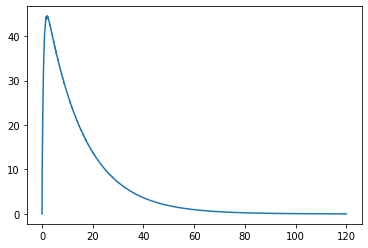

In [22]:
plot_best_fit(de_results[15][1],de_results[15][0], df_pk_paras)

In [17]:
# Export and save the trajectory data in pickle file
# with open('trajectory_data_python_final.pkl', 'wb') as handle:
#     pickle.dump(trajectory_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Plotting trajectories

In [23]:
# Reading pickle file (stored trajectory data) generated from Python DE earlier
with open('trajectory_data_python_final.pkl', 'rb') as handle:
    trajectory_data = pickle.load(handle)

In [24]:
trajectories = list(trajectory_data)
trajectories

[{1: <zip at 0x14b5f1df748>},
 {2: <zip at 0x14b5f2deac8>},
 {3: <zip at 0x14b5f2de908>},
 {4: <zip at 0x14b5f2def48>},
 {5: <zip at 0x14b5f2dea88>},
 {6: <zip at 0x14b5f26d308>},
 {7: <zip at 0x14b5f210188>},
 {8: <zip at 0x14b5f2b1588>},
 {9: <zip at 0x14b5f2b1cc8>},
 {10: <zip at 0x14b5f2d7e08>},
 {11: <zip at 0x14b5f2d7908>},
 {12: <zip at 0x14b5f2d7708>},
 {13: <zip at 0x14b5f2d75c8>},
 {14: <zip at 0x14b5f2d7cc8>},
 {15: <zip at 0x14b5f2e9248>},
 {16: <zip at 0x14b5f2e94c8>},
 {17: <zip at 0x14b5f2e9708>},
 {18: <zip at 0x14b5f2e9948>},
 {19: <zip at 0x14b5f2e9b48>},
 {20: <zip at 0x14b5f2e9dc8>},
 {21: <zip at 0x14b5f2e2048>},
 {22: <zip at 0x14b5f2e2288>},
 {23: <zip at 0x14b5f2e24c8>},
 {24: <zip at 0x14b5f2e2708>},
 {25: <zip at 0x14b5f2e2948>},
 {26: <zip at 0x14b5f2e2b88>},
 {27: <zip at 0x14b5f2e2dc8>},
 {28: <zip at 0x14b5f2e6048>},
 {29: <zip at 0x14b5f2e6288>},
 {30: <zip at 0x14b5f2e64c8>},
 {31: <zip at 0x14b5f2e6708>},
 {32: <zip at 0x14b5f2e6948>},
 {33: <zip at 0x1

In [25]:
# Unpacking the concentration time trajectory data for each subject
subject_traj = []

for i in range(1,len(trajectories)+1):
    data = trajectories[i-1][i]
    time_x, conc_y = zip(*data)
    subject_df = pd.DataFrame({'time':time_x,
                                'conc':conc_y})
    subject_traj.append(subject_df)

In [26]:
subject_traj[0].head()

,time,conc
0,0.000,0.000000
1,0.017,7.890143
2,0.033,10.257354
3,0.050,11.459664
4,0.067,12.316301


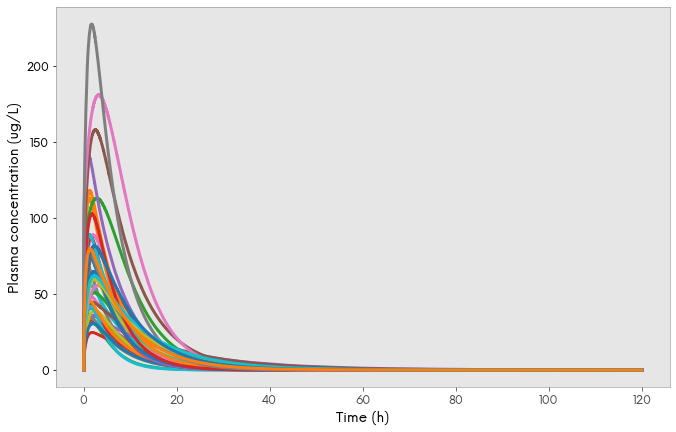

In [27]:
# All 42 subjects
plt.figure(figsize=(11,7))
plt.xlabel('Time (h)')
plt.ylabel('Plasma concentration (ug/L)')

for subject in subject_traj:
    plt.plot(subject.time, subject.conc)
    
plt.savefig('./Images/all_trajectories.png', **savefigOpts)

#### Comparing with actual raw data

In [41]:
path = '.\Samples'
files = os.listdir(path)
files_xls = [f for f in files if f[-4:] == 'xlsx']
files_xls

['subject03_ref22.xlsx',
 'subject06_ref25_adult_males_single_20mg.xlsx',
 'subject07_ref25_elderly_males_single_20mg.xlsx',
 'subject15_ref25_adult_females_single_20mg.xlsx',
 'subject16_ref25_elderly_females_single_20mg.xlsx',
 'subject19_ref31_15mg.xlsx',
 'subject22_ref25_adults_males_multi_20mg.xlsx',
 'subject23_ref25_elderly_males_multi_20mg.xlsx',
 'subject25_ref33_30mg.xlsx',
 'subject26_ref31_30mg.xlsx',
 'subject33_ref31_45mg.xlsx',
 'subject36_ref31_60mg.xlsx',
 'subject37_ref31_75mg.xlsx',
 'subject39_ref25_adults_females_multi_20mg.xlsx',
 'subject40_ref25_elderly_females_multi_20mg.xlsx']

In [28]:
# 15 cohort subjects with real raw time-conc data
subject_id_list = [3,6,7,15,16,19,22,23,25,26,33,36,37,39,40]

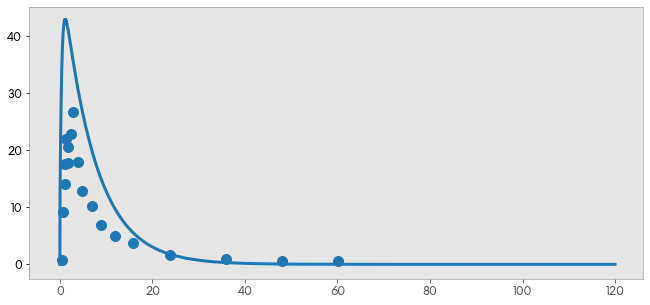

In [49]:
# Using cohort PK vs individual data (Will not be perfect fit because we are using mean PK values)
plt.figure(figsize=(11,5))
plt.title = f'subject_id_list[0]'
plt.plot(subject_traj[subject_id_list[0]].time, subject_traj[subject_id_list[0]].conc);
subject_raw = pd.read_excel(f'./Samples/{files_xls[0]}')
plt.scatter(subject_raw.time, subject_raw.conc)
plt.show()

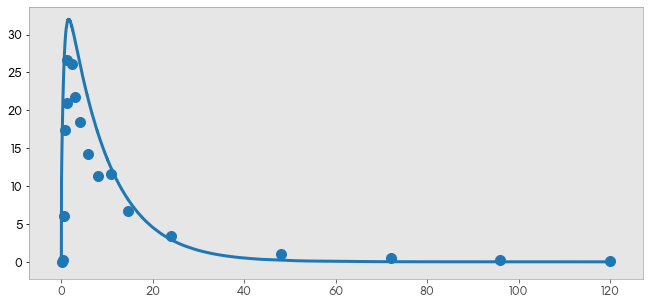

In [33]:
subject_id = 6
plt.figure(figsize=(11,5))
plt.plot(subject_traj[subject_id-1].time, subject_traj[subject_id-1].conc);
subject_raw = pd.read_excel('./Samples/subject06_ref25_adult_males_single_20mg.xlsx')
plt.scatter(subject_raw.time, subject_raw.conc);

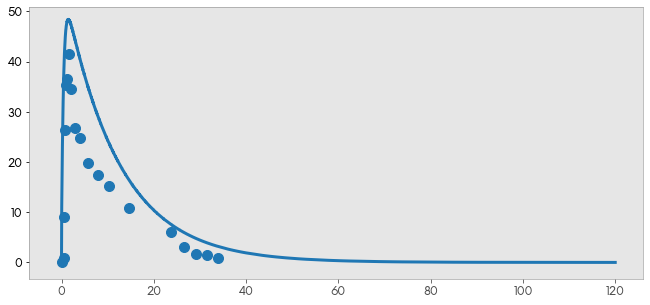

In [34]:
subject_id = 7
plt.figure(figsize=(11,5))
plt.plot(subject_traj[subject_id-1].time, subject_traj[subject_id-1].conc);
subject_raw = pd.read_excel('./Samples/subject07_ref25_elderly_males_single_20mg.xlsx')
plt.scatter(subject_raw.time, subject_raw.conc);

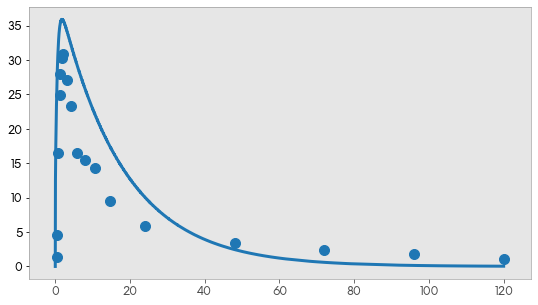

In [35]:
subject_id = 15
plt.figure(figsize=(11,5))
plt.plot(subject_traj[subject_id-1].time, subject_traj[subject_id-1].conc);
subject_raw = pd.read_excel('./Samples/subject15_ref25_adult_females_single_20mg.xlsx')
plt.scatter(subject_raw.time, subject_raw.conc);

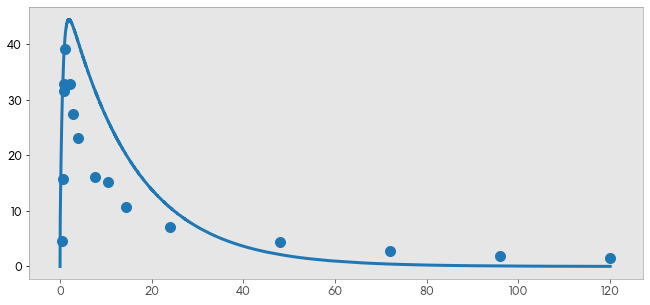

In [37]:
subject_id = 16
plt.figure(figsize=(11,5))
plt.plot(subject_traj[subject_id-1].time, subject_traj[subject_id-1].conc);
subject_raw = pd.read_excel('./Samples/subject16_ref25_elderly_females_single_20mg.xlsx')
plt.scatter(subject_raw.time, subject_raw.conc);

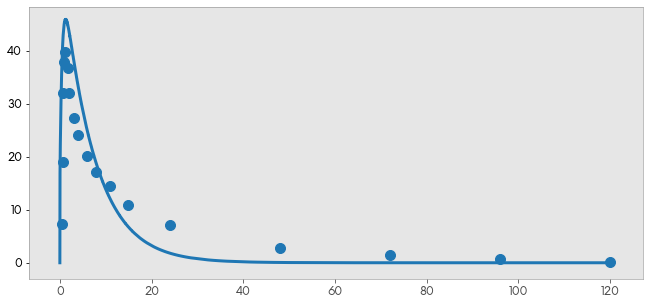

In [38]:
subject_id = 22
plt.figure(figsize=(11,5))
plt.plot(subject_traj[subject_id-1].time, subject_traj[subject_id-1].conc);
subject_raw = pd.read_excel('./Samples/subject22_ref25_adults_males_multi_20mg.xlsx')
plt.scatter(subject_raw.time, subject_raw.conc);

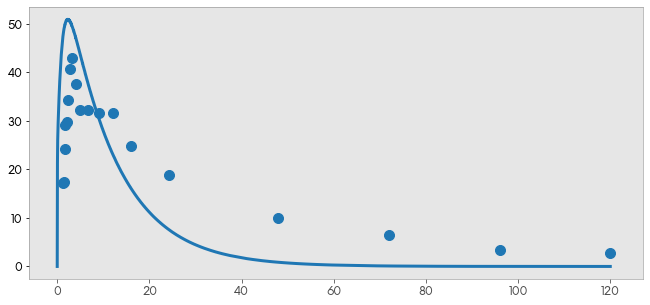

In [39]:
subject_id = 23
plt.figure(figsize=(11,5))
plt.plot(subject_traj[subject_id-1].time, subject_traj[subject_id-1].conc);
subject_raw = pd.read_excel('./Samples/subject23_ref25_elderly_males_multi_20mg.xlsx')
plt.scatter(subject_raw.time, subject_raw.conc);

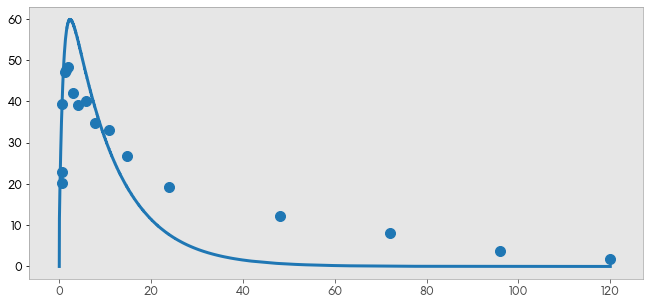

In [40]:
subject_id = 39
plt.figure(figsize=(11,5))
plt.plot(subject_traj[subject_id-1].time, subject_traj[subject_id-1].conc);
subject_raw = pd.read_excel('./Samples/subject39_ref25_adults_females_multi_20mg.xlsx')
plt.scatter(subject_raw.time, subject_raw.conc);

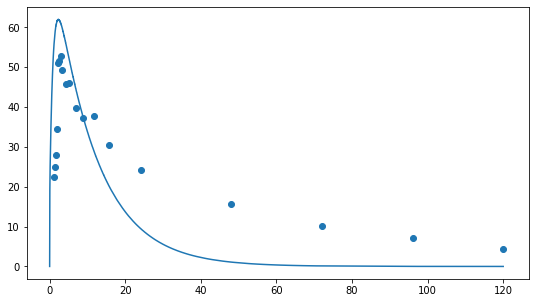

In [12]:
subject_id = 40
plt.figure(figsize=(9,5))
plt.plot(subject_traj[subject_id-1].time, subject_traj[subject_id-1].conc);
subject_raw = pd.read_excel('./Samples/subject40_ref25_elderly_females_multi_20mg.xlsx')
plt.scatter(subject_raw.time, subject_raw.conc);

#### Gender (Compare at doses 20mg)

In [29]:
male_subject_indices = df_subject_master.index[(df_subject_master['gender'] == 0) & 
                                               (df_subject_master['dose'] == 20)].tolist()
male_subject_indices

[5, 6, 21, 22]

In [30]:
female_subject_indices = df_subject_master.index[(df_subject_master['gender'] == 1) & 
                                               (df_subject_master['dose'] == 20)].tolist()
female_subject_indices

[14, 15, 38, 39]

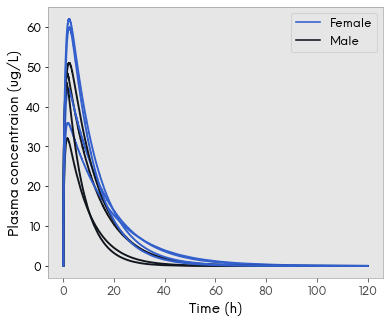

In [31]:
plt.figure(figsize=(6,5))

for index, subject in enumerate(subject_traj):
    if index in male_subject_indices:
        plt.plot(subject.time, subject.conc, color = color_scheme[0], label = 'Male', linewidth = 1.9)
        plt.xlabel('Time (h)')
        plt.ylabel('Plasma concentraion (ug/L)')
        
    if index in female_subject_indices:
        plt.plot(subject.time, subject.conc, color = color_scheme[1], label = 'Female', linewidth = 1.9)

custom_lines = [Line2D([0], [0], color=color_scheme[1], lw=1.6),
                Line2D([0], [0], color=color_scheme[0], lw=1.6)]
plt.legend(custom_lines, ['Female', 'Male'], fontsize = 12);
plt.savefig('./Images/gender_trajectory_comparison.png', **savefigOpts)

In [32]:
# Time column
time_col = subject_traj[0][['time']]

In [33]:
# Average trajectory
male_conc_list = []
female_conc_list = []

for index, subject in enumerate(subject_traj):
    if index in male_subject_indices:
        male_conc_list.append(subject[['conc']])
    if index in female_subject_indices:
        female_conc_list.append(subject[['conc']])

#### Function to generate average trajectories for subpopulation

In [34]:
def gen_subpop_trajectory(conc_list):
    conc = pd.DataFrame(pd.concat(conc_list, axis=1))
    conc['mean_conc'] = conc.mean(axis=1)
    conc_mean = conc[['mean_conc']]
    conc_final = pd.concat([time_col, conc_mean], axis = 1)
    return conc_final

In [35]:
male_avr = gen_subpop_trajectory(male_conc_list)
female_avr = gen_subpop_trajectory(female_conc_list)

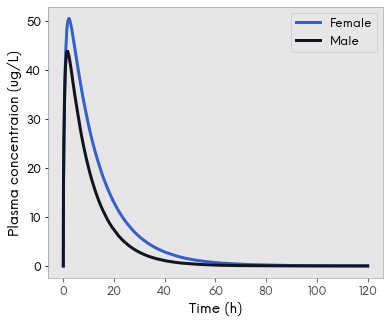

In [36]:
plt.figure(figsize=(6,5))
plt.xlabel('Time (h)')
plt.ylabel('Plasma concentraion (ug/L)')
plt.plot(female_avr.time, female_avr.mean_conc, color = color_scheme[1], label = 'Female');
plt.plot(male_avr.time, male_avr.mean_conc, color = color_scheme[0], label = 'Male');
plt.legend(fontsize=12, labels = ['Female','Male']);
plt.savefig('./Images/avr_gender_trajectory_comparison.png', **savefigOpts)

### Age (Compare at 20 mg)

In [37]:
ageband_1_indices = df_subject_master.index[(df_subject_master['age_mean'] <= 25) & 
                                               (df_subject_master['dose'] == 20)].tolist()
ageband_2_indices = df_subject_master.index[(df_subject_master['age_mean'] >= 26) & (df_subject_master['age_mean'] <= 59) & \
                                               (df_subject_master['dose'] == 20)].tolist()
ageband_3_indices = df_subject_master.index[(df_subject_master['age_mean'] >= 60) & 
                                               (df_subject_master['dose'] == 20)].tolist()

In [43]:
ageband_3_indices

[6, 15, 22, 39]

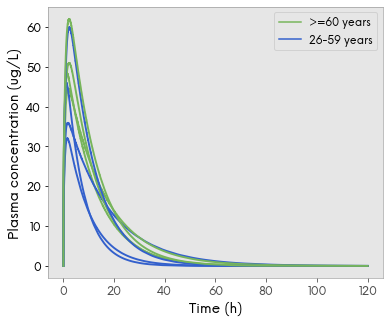

In [38]:
plt.figure(figsize=(6,5))

for index, subject in enumerate(subject_traj):
    if index in ageband_1_indices:
        plt.plot(subject.time, subject.conc, color = color_scheme[0], linewidth = 1.9)
        plt.xlabel('Time (h)')
        plt.ylabel('Plasma concentration (ug/L)')
        
    if index in ageband_2_indices:
        plt.plot(subject.time, subject.conc, color = color_scheme[1], linewidth = 1.9)
        plt.xlabel('Time (h)')
        plt.ylabel('Plasma concentration (ug/L)')
        
    if index in ageband_3_indices:
        plt.plot(subject.time, subject.conc, color = color_scheme[2], linewidth = 1.9)
        plt.xlabel('Time (h)')
        plt.ylabel('Plasma concentration (ug/L)')
        
custom_lines = [Line2D([0], [0], color=color_scheme[2], lw=1.5),
               Line2D([0], [0], color=color_scheme[1], lw=1.5),
               Line2D([0], [0], color=color_scheme[0], lw=1.5)]

plt.legend(custom_lines, ['>=60 years', '26-59 years'], fontsize = 11);

plt.savefig('./Images/age_trajectory_comparison.png', **savefigOpts)

In [39]:
# Average trajectory (Age)
ageband_1_conc_list = []
ageband_2_conc_list = []
ageband_3_conc_list = []

for index, subject in enumerate(subject_traj):
    if index in ageband_1_indices:
        ageband_1_conc_list.append(subject[['conc']])
    if index in ageband_2_indices:
        ageband_2_conc_list.append(subject[['conc']])
    if index in ageband_3_indices:
        ageband_3_conc_list.append(subject[['conc']])

In [ ]:
ageband_1_avr = gen_subpop_trajectory(ageband_1_conc_list)
ageband_2_avr = gen_subpop_trajectory(ageband_2_conc_list)
ageband_3_avr = gen_subpop_trajectory(ageband_3_conc_list)

In [ ]:
plt.figure(figsize=(6,5))
plt.xlabel('Time (h)')
plt.ylabel('Plasma concentraion (ug/L)')
plt.plot(ageband_1_avr.time, ageband_1_avr.mean_conc, color = color_scheme[0], label = '<35 yrs old');
plt.plot(ageband_2_avr.time, ageband_2_avr.mean_conc, color = color_scheme[1], label = '35 - 65 yrs old');
plt.plot(ageband_3_avr.time, ageband_3_avr.mean_conc, color = color_scheme[2], label = '>65 yrs old');
plt.legend(fontsize=12, labels = ['<35 yrs old', '35 - 65 yrs old', '>65 yrs old']);
plt.savefig('./Images/avr_age_trajectory_comparison.png', **savefigOpts)